In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from itertools import product

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

In [4]:
from PIL import Image
class Resize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, img):
        return img.resize((self.width, self.height), Image.BICUBIC)

# Data

In [5]:
N = 14
NUM_CLASSES = 10
SEED = 42

In [6]:
transforms = torchvision.transforms.Compose([
    Resize(N, N),
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [7]:
train_dataset = datasets.MNIST(root='../data', train=True, download=False, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [8]:
test_dataset = datasets.MNIST(root='../data', train=False, download=False, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

7


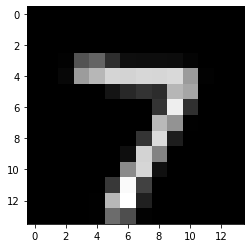

In [9]:
for img, label in test_loader: break
imshow(img[0].reshape(N, N), label=label[0].item())

In [10]:
def loader_to_mat(loader, size):
    X = []
    y = []
    i = 0
    for b in loader:
        i+=1
        X.append(b[0].flatten())
        y.append(b[1].flatten())
        if i == size:
            break
    return torch.stack(X).numpy(), np.array(y)

## K-means 

In [11]:
def get_distance(a, b):
    return np.sqrt(np.sum((a-b)**2))

In [12]:
def kmeans(xs, k, max_iters=1000):
    conv = False
    centroids = xs[np.random.choice(range(len(xs)), size=k, replace=False)]
    
    it = 0
    while (not conv) and it < max_iters:
        clusters = [[] for _ in range(len(centroids))]
        for x in xs:
            min_dist = np.inf
            closest_c = -1
            for j, c in enumerate(centroids):
                dist = get_distance(x, c)
                if dist < min_dist:
                    min_dist = dist
                    closest_c = j
            clusters[closest_c].append(x)
        clusters = [c for c in clusters if c]
        prev_centroids = centroids.copy()
        centroids = [np.mean(c, axis=0) for c in clusters]
        
        conv = len(prev_centroids) == len(centroids) and np.allclose(prev_centroids, centroids)
        it += 1

    max_d = -1
    for i in range(len(centroids)):
        for j in range(i, len(centroids)):
            max_d = max(get_distance(centroids[i], centroids[j]), max_d)
            
    return np.array(centroids), [max_d for c in clusters]

In [13]:
from sklearn.datasets import make_blobs

In [14]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0, cluster_std=0.8)

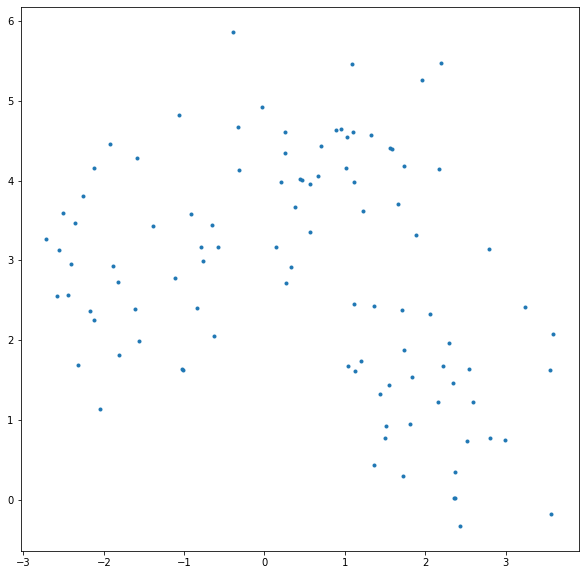

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], '.')

In [16]:
centroids, stds = kmeans(X, 3)

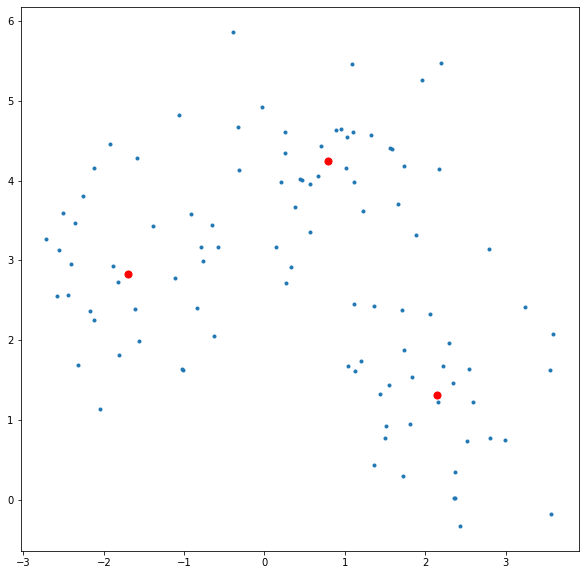

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], '.')
plt.scatter(centroids[:, 0], centroids[:, 1], s=50, color='red')

In [18]:
def kmeans_fast(xs, k, max_iters):
    from sklearn.cluster import KMeans
    centroids = KMeans(max_iter=max_iters).fit(xs, k).cluster_centers_

    max_d = -1
    for i in range(len(centroids)):
        for j in range(i, len(centroids)):
            max_d = max(get_distance(centroids[i], centroids[j]), max_d)
    return np.array(centroids), [max_d for c in centroids]

# Model 

In [19]:
class RBNFModel():
    def __init__(self, n_in, k, n_classes, kmeans_imp=kmeans_fast):
        self.n_in = n_in
        self.k = k #like hidden
        self.n_classes = n_classes
        self.kmeans_imp = kmeans_imp
        self.centroids = None
        self.stds = None
        self.W = None

    def one_hot(self, label):
        return np.eye(self.n_classes)[label]
     
    def predict(self, X):
        assert self.W is not None, 'Not fitted yet'
        rbf_X = self.clusterize(X, self.centroids, self.stds)        
        out = rbf_X @ self.W
        pred = np.argmax(out, axis=1)
        return pred

    def rbf(self, x, c, s):
        return 1 / np.exp(-get_distance(x, c) / s ** 2)

    def clusterize(self, X, centroids, stds):
        xs_clusters_distrib = []
        for x in X:
            clusters_distrib = []
            for c, s in zip(centroids, stds):
                clusters_distrib.append(self.rbf(x, c, s))
            xs_clusters_distrib.append(np.array(clusters_distrib))
        return np.array(xs_clusters_distrib)
    
    
    def fit(self, X, y):
        target = self.one_hot(y)
        self.centroids, self.stds = self.kmeans_imp(X, self.k, max_iters=1000)
        rbf_X = self.clusterize(X, self.centroids, self.stds)
            
        self.W = np.linalg.pinv(rbf_X.T @ rbf_X) @ rbf_X.T @ target
        
        out = rbf_X @ self.W
        pred = np.argmax(out, axis=1)
        
        return sum(pred == y) / len(y)
        
    def test(self, X, y):
        rbf_X = self.clusterize(X, self.centroids, self.stds)
        out = rbf_X @ self.W
        pred = np.argmax(out, axis=1)
        return sum(pred == y) / len(y)


In [20]:
model = RBNFModel(N*N, 300, NUM_CLASSES)

In [21]:
TRAIN_SIZE = 100_000
TEST_SIZE = 1_00

In [22]:
X_train, y_train = loader_to_mat(train_loader, TRAIN_SIZE)
X_test, y_test = loader_to_mat(test_loader, TEST_SIZE)

In [23]:
from collections import namedtuple
Expr = namedtuple('expr', 'k, train_acc, test_acc')

In [ ]:
exprs = []
for k in range(10, N*N, 20):
    model = RBNFModel(N*N, k, NUM_CLASSES)
    print(f'k: {k}')
    train_acc = model.fit(X_train, y_train)
    test_acc = model.test(X_test, y_test)
    exprs.append(Expr(k, train_acc, test_acc))
    print(f'test acc: {test_acc}')
    print('-' * 20)

k: 10
test acc: 0.67
--------------------
k: 30
test acc: 0.67
--------------------
k: 50


In [ ]:
print('accuracy')
print(f'{"K":>3}{"train":>10}{"test":>8}')
print('-'*30)
for exp in exprs:
    print(f'{exp.k:>3}{exp.train_acc:10.3f}{exp.test_acc:>8.3f}')


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
for img, gt, pred in zip(X_test, y_test, y_pred):
    if gt == pred:
        continue
    imshow(img.reshape(N, N), label=f'gt: {gt}\npr: {pred}')